In [1]:
from __future__ import division
from __future__ import print_function
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn import cross_validation
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
from nltk import word_tokenize

import re
from HTMLParser import HTMLParser
import datetime
import cPickle as pickle
pd.options.mode.chained_assignment = None  # default='warn'

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

In [2]:
# Files
all_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withindgroup/all_withindgroup.txt'
tech_file = '/Users/lekha/galvanize/capstone/projectRiley/data/withindgroup/tech_withind.txt'
hadoop_all = '/Users/lekha/galvanize/capstone/projectRiley/data/withindgroup/all_hadoop.txt'
hadoop_tech = '/Users/lekha/galvanize/capstone/projectRiley/data/withindgroup/tech_hadoop.txt'

In [3]:
dfall1 = pd.read_csv(all_file, sep="|")
dftech1 = pd.read_csv(tech_file, sep="|")
dfh = pd.read_csv(hadoop_all, sep="|")
dfht = pd.read_csv(hadoop_tech, sep="|")

In [4]:
dftech_all = pd.concat([dftech1, pd.read_csv(hadoop_tech, sep="|")], axis=0)

In [5]:
df_all2 = pd.concat([dfall1, pd.read_csv(hadoop_all, sep="|")], axis=0)

In [ ]:
df_all2.to_csv('/Users/lekha/galvanize/capstone/projectRiley/data/withindgroup/all2.txt', sep="|", index=False)
dftech_all.to_csv('/Users/lekha/galvanize/capstone/projectRiley/data/withindgroup/tech_all2.txt', sep="|", index=False)

In [7]:
df = df_all2.copy()

In [8]:
df['first_name'] = df['first_name'].apply(lambda x:'andrew' if x=='anew' else x)
df.loc[df.first_name.isin(['andrew']), 'gender'] = 'male'

# Modeling - Original Data

In [9]:
# Functions
def missing(df):
    if df.summary == 'missing' or df.num_tokens == 0:
        return 1
    else:
        return 0    

    
def lenx(mystr):
    return len(mystr.split())


def avgchrs(mytokens):
    tw = len(mytokens)    
    num_chars = 0
    for word in mytokens:
        num_chars += len(word)        
    return num_chars/tw


def remove_digits(mystr):
    '''
    INPUT: list of tokens 
    OUTPUT: list of tokens with digits removed
    '''
    return [word for word in mystr if not word.isdigit()]


stemmer = SnowballStemmer("english")
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed


def tokenize(text):
    tokens = word_tokenize(text)
    row = remove_digits(tokens)
    stems = stem_tokens(row, stemmer)
    return stems


def tokenize_no_stem(text):
    tokens = word_tokenize(text)
    row = remove_digits(tokens)
    stems = stem_tokens(row, stemmer)
    return tokens 


In [10]:
def preprocess_df(df):
    # Feature Engineering before running the prediction code
    df['class'] = np.ones(len(df))
    df['class'] = df['gender_forced'].apply(lambda x: 0 if x == 'female' else 1)

    df['summ_tokens'] = df['summary'].apply(lambda x: nltk.word_tokenize(str(x)))
    df['num_tokens'] = df['summ_tokens'].apply(lambda x: len(x))

    # Add feature for missing summary
    df['summ_missing'] = df.apply(missing, axis = 1)

    # Only include rows with summaries
    df = df[df['summ_missing'] == 0]

    # Some Nan rows refuse to go without this
    df = df[pd.notnull(df['summary'])]

    print ("Length of DF after removing rows with missing Summaries:\n")
    print (len(df))

    df['avg_len'] = df['summ_tokens'].apply(lambda x: avgchrs(x))

    # lexical diversity = number of unique tokens / total number of tokens
    df['lex_diversity'] = df['summ_tokens'].apply(lambda x: len(set(x))/len(x))
    
    return df

In [11]:
def rf_predict(df):
# Train-test split

    X_train, X_test, y_train, y_test = train_test_split(df['summary'], df['class'], test_size=0.3, random_state=0)
    vectorizer = CountVectorizer(analyzer = 'word', tokenizer = tokenize, ngram_range=(1,4), stop_words = stopwords, max_df = 0.7, min_df = 5, max_features = 5000)
    train_fit = vectorizer.fit_transform(X_train)
    train_fit = train_fit.toarray()
    feature_names = vectorizer.get_feature_names()

    print ("Training the random forest...")

    # Initialize a Random Forest classifier with 100 trees
    forest = RandomForestClassifier(n_estimators = 100) 

    # Fit the forest to the training set, using the bag of words as 
    # features and the sentiment labels as the response variable
    #
    # This may take a few minutes to run
    forest = forest.fit(train_fit, y_train)

    # Testing

    # Get a bag of words for the test set, and convert to a numpy array
    #test_data_features = vectorizer.transform(X_test)
    test_features = vectorizer.transform(X_test)
    test_features = test_features.toarray()

    # Use the random forest to make sentiment label predictions
    yhat = forest.predict(test_features)
    probX = forest.predict_proba(test_features)

    print ("Precision Score: {0}".format(precision_score(y_test, yhat)))
    print ("Recall Score: {0}".format(recall_score(y_test, yhat)))
    print ("AUC Score: {0}".format(roc_auc_score(y_test, yhat)))
    print ("Model Score:{0}".format(forest.score(test_features, y_test)))
    
    fpr, tpr, thresholds = roc_curve(y_test, probX[:,1])    
    
    # Most important features
    num = 50
    imp = forest.feature_importances_
    feature_names = np.array(feature_names)
    features = feature_names[np.argsort(imp)[-num:]]
    weights = imp[np.argsort(imp)[-num:]]
    feats_with_vals = zip(features, weights)
    print ("Top 50 Features\n")
    for x in feats_with_vals:
        print (x)

        
    ## Naive Bayes Classifier
    nb_model = MultinomialNB()
    fitted_data = nb_model.fit(train_fit, y_train)
    yhat_nb = nb_model.predict(test_features)
    prob_nb = nb_model.predict_proba(test_features)
    
    print (nb_model)
    print ("Precision Score: {0}".format(precision_score(y_test, yhat_nb)))
    print ("Recall Score: {0}".format(recall_score(y_test, yhat_nb)))
    print ("AUC Score: {0}".format(roc_auc_score(y_test, yhat_nb)))
    print ("Model Score:{0}".format(nb_model.score(test_features, y_test)))

    fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, prob_nb[:,1])
    
    ## Logistic Regression
    lr_model = LogisticRegression()
    fitted_data = lr_model.fit(train_fit, y_train)
    yhat_lr = lr_model.predict(test_features)
    prob_lr = lr_model.predict_proba(test_features)
    
    print (lr_model)
    print ("Precision Score: {0}".format(precision_score(y_test, yhat_lr)))
    print ("Recall Score: {0}".format(recall_score(y_test, yhat_lr)))
    print ("AUC Score: {0}".format(roc_auc_score(y_test, yhat_lr)))
    print ("Model Score:{0}".format(lr_model.score(test_features, y_test)))

    fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, prob_lr[:,1])
        
    
    # ROC Curve
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)

    plt.plot(np.array(range(101))/100, np.array(range(101))/100, '--', color='black')
    plt.plot(fpr, tpr, label='rf-tfidf')
    plt.plot(fpr_nb, tpr_nb, label='Naive Bayes')
    plt.plot(fpr_lr, tpr_lr, label='Logistic')
    plt.ylabel("True Positive Rate ")
    plt.xlabel("False Positive Rate")
    plt.title("ROC plot")
    plt.legend(loc='lower right')

    plt.grid()
    plt.show()

In [ ]:
# Model 1
rf_predict(df)

In [ ]:
dftech1 = preprocess_df(dftech1)
rf_predict(dftech1)

In [ ]:
dfh = preprocess_df(dfh)
rf_predict(dfh)

In [ ]:
dfht = preprocess_df(dfht)
rf_predict(dfht)

In [ ]:
df_all2 = preprocess_df(df_all2)
rf_predict(df_all2)

In [ ]:
dftech_all = preprocess_df(dftech_all)
rf_predict(dftech_all)

In [ ]:
# with 3 grams

df_all2 = preprocess_df(df_all2)
rf_predict(df_all2)

Length of DF after removing rows with missing Summaries:

26850
Training the random forest...
Precision Score: 0.675726927939
Recall Score: 0.729029324847
AUC Score: 0.654038732445
Model Score:0.660955927995
Top 50 Features

(u'current', 0.0014985953477382602)
(u'team', 0.0015100695288498562)
(u'event', 0.0015117997863537183)
(u'analysi', 0.0015148800757801622)
(u'new', 0.0015407223586969021)
(u'servic', 0.0015424769228418839)
(u'scienc', 0.001545393009617095)
(u'interest', 0.0015454895924548917)
(u'organ', 0.0015467113655514633)
(u'public', 0.0015629785789579528)
(u'plan', 0.0015714431320324354)
(u'includ', 0.00160303076732878)
(u'applic', 0.0016156899365262116)
(u'startup', 0.0016309093563141813)
(u'industri', 0.0016749853939573569)
(u'profession', 0.0018129037845946883)
(u'program', 0.0018534942565198922)
(u'event plan', 0.0018646951090823733)
(u'market', 0.001866248227858164)
(u'year', 0.0018758818371407276)
(u'creativ', 0.0018875094772340972)
(u'nonprofit', 0.0019071091511574842)


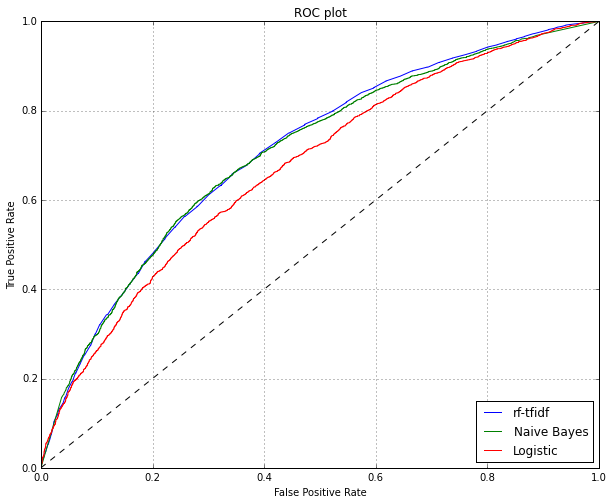

In [12]:
# with 3 grams and Adding Naive Bayes and Logistic Regression

df_all2 = preprocess_df(df_all2)
rf_predict(df_all2)

Length of DF after removing rows with missing Summaries:

5008
Training the random forest...
Precision Score: 0.739416058394
Recall Score: 0.944962686567
AUC Score: 0.558328211033
Model Score:0.723220226214
Top 50 Features

(u'research', 0.0014021487709581621)
(u'current', 0.0014049095289914635)
(u'human', 0.001428872331827714)
(u'digit', 0.0014388294182158868)
(u'peopl', 0.0014553479791328432)
(u'profession', 0.0014750452167510302)
(u'passion', 0.0014824476804228403)
(u'skill', 0.0014964948317193543)
(u'data', 0.0015262424443268489)
(u'includ', 0.0015357219874330714)
(u'learn', 0.0015361630817395597)
(u'servic', 0.0015365585713023064)
(u'univers', 0.0015893335754268343)
(u'artist', 0.001600424192035539)
(u'program', 0.0016031492797819568)
(u'custom', 0.0016032904883576751)
(u'user research', 0.00161294289608555)
(u'use', 0.0016523800528734885)
(u'illustr', 0.0016564675157316952)
(u'creat', 0.00166154723729673)
(u'user experi', 0.0016630494413222986)
(u'market', 0.0016664213932705426)


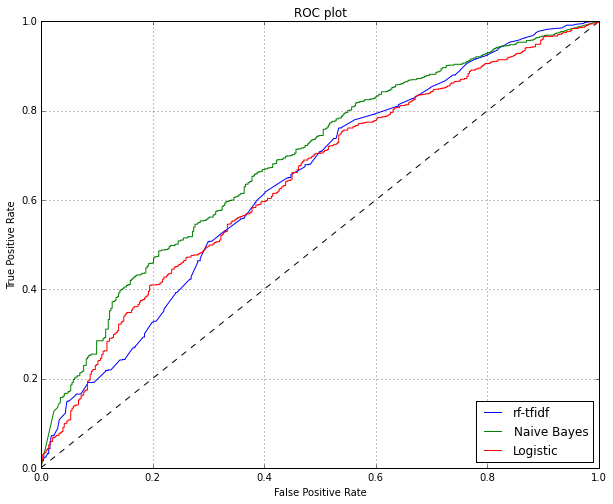

In [13]:
dftech_all = preprocess_df(dftech_all)
rf_predict(dftech_all)

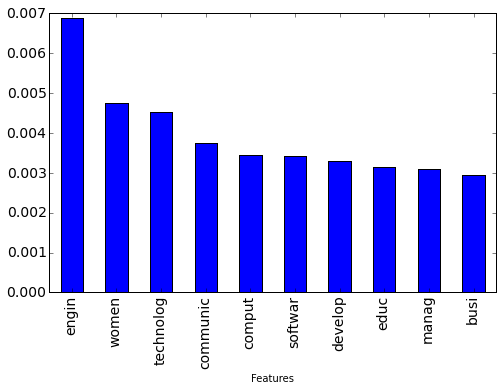

In [24]:


data = {'Features':labels,
        'Weights':wts}



featdf = pd.DataFrame(data, columns = ['Features', 'Weights'])

featdf.plot(kind='bar', x=featdf['Features'], fontsize=14, figsize=(8, 5), legend=False)



In [21]:
## Printing out the Random Forest Tree

X_train, X_test, y_train, y_test = train_test_split(df['summary'], df['class'], test_size=0.3, random_state=0)
vectorizer = CountVectorizer(analyzer = 'word', tokenizer = tokenize, ngram_range=(1,4), stop_words = stopwords, max_df = 0.7, min_df = 5, max_features = 5000)
train_fit = vectorizer.fit_transform(X_train)
train_fit = train_fit.toarray()
feature_names = vectorizer.get_feature_names()

print ("Training the random forest...")

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit(train_fit, y_train)

# Testing

# Get a bag of words for the test set, and convert to a numpy array
#test_data_features = vectorizer.transform(X_test)
test_features = vectorizer.transform(X_test)
test_features = test_features.toarray()

# Use the random forest to make sentiment label predictions
yhat = forest.predict(test_features)
probX = forest.predict_proba(test_features)

print ("Precision Score: {0}".format(precision_score(y_test, yhat)))
print ("Recall Score: {0}".format(recall_score(y_test, yhat)))
print ("AUC Score: {0}".format(roc_auc_score(y_test, yhat)))
print ("Model Score:{0}".format(forest.score(test_features, y_test)))

fpr, tpr, thresholds = roc_curve(y_test, probX[:,1])    

# Most important features
num = 50
imp = forest.feature_importances_
feature_names = np.array(feature_names)
features = feature_names[np.argsort(imp)[-num:]]
weights = imp[np.argsort(imp)[-num:]]
feats_with_vals = zip(features, weights)
print ("Top 50 Features\n")
for x in feats_with_vals:
    print (x)


In [22]:
labels

['engin',
 'women',
 'technolog',
 'communic',
 'comput',
 'softwar',
 'develop',
 'educ',
 'manag',
 'busi']

In [23]:
wts

[0.00688,
 0.00476,
 0.00454,
 0.00375,
 0.00345,
 0.00343,
 0.00331,
 0.00316,
 0.00309,
 0.00295]